In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import glob
import h5py
from sklearn import preprocessing
# import datetime
%matplotlib inline

In [3]:
stock = ['CATY']
V = 500       #shares
lot = 100      #shares per lot
noLot = int(V/lot)   #no of lots
T = 5           #mins to execute T shares

interval = 30   #mins, coefficients of price impacts change every 30 mins
timeStep = 30   #seconds
noStep = int(T * 60/timeStep)     #number of time step for each episode
noEpi = 6.5/(interval/60)  #per day, each day there are 6.5 trading hours

stock = ['CATY']
inputFolder = 'C:\\Users\\I535982\\Documents\\Uni\\Thesis\\Data\\Output'            #'C:\\Users\\I535982\\Documents\\Uni\\Thesis\\Data\\Simulation\\Data'   
for s in stock:
    sInputFolder = inputFolder + '\\' + s + '\\Training'
    df = pd.read_csv(sInputFolder + '\\' + '0BestPrice_Replay1.csv')         # uniform replay
    df2 = pd.read_csv(sInputFolder + '\\' + '0BestPrice_Replay2.csv')       # prioritized replay
    h5f = h5py.File(sInputFolder + '\\' + 'BestPrice_Replay10.10.h5','r')
    h5f2 = h5py.File(sInputFolder + '\\' + 'BestPrice_Replay20.10.h5','r')

In [4]:
print(df2.columns.values)
df2.head()

['timeStamp' 'second' 'bestBidPrice' 'bestAskPrice' 'best2BidPrice'
 'best2AskPrice' 'OFI' 'bidTradeSize' 'askTradeSize' 'marDep' 'noEvent'
 'bestBidVol' 'bestAskVol' 'noTrade' 'midPrice' 'spread' 'priceChange'
 'MA' 'subSample' 'step' '1stFill' '2ndFill' '2ndFillRo' 'minDate' 'epi'
 'tradingVol' 'tradingImb' 'aveMD' 'orderImb' 'movingDiff' 'TISquared'
 'TVSquaredRoot' 'const' 'OFICoeff' 'TICoeff' 'OICoeff' 'optimalQ1'
 'optimalAType1' 'optimalA1' 'accReward1' 'timeStep' 'microPrice' 'Act'
 'tradingVolBin' 'tradingImbBin' 'movingDiffBin' 'spreadBin' 'OFIBin'
 'aveMDBin' 'orderImbBin' 'optimalQ0.1' 'optimalAType0.1' 'optimalA0.1'
 'accReward0.1']


,timeStamp,second,bestBidPrice,bestAskPrice,best2BidPrice,best2AskPrice,OFI,bidTradeSize,askTradeSize,marDep,...,tradingImbBin,movingDiffBin,spreadBin,OFIBin,aveMDBin,orderImbBin,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1
0,2019-10-01 09:30:00.420,0.420,31.55,35.78,31.20,36.70,0,0,0,0,...,0,0,2,1,0,1,NaN,NaN,NaN,NaN
1,2019-10-01 09:30:32.600,32.600,34.52,35.00,34.50,35.13,209,0,0,19701,...,0,2,2,2,2,0,NaN,NaN,NaN,NaN
2,2019-10-01 09:31:00.009,60.009,34.53,35.00,34.51,35.13,0,0,0,15210,...,0,2,2,1,2,0,NaN,NaN,NaN,NaN
3,2019-10-01 09:31:34.695,94.695,34.74,35.00,34.73,35.12,500,0,0,28618,...,0,2,2,2,2,0,NaN,NaN,NaN,NaN
4,2019-10-01 09:32:00.486,120.486,34.75,35.00,34.73,35.12,-60,0,0,7435,...,0,2,2,1,2,0,NaN,NaN,NaN,NaN


In [5]:
df2['state'] = df2['tradingVolBin'].apply(str) + df2['tradingImbBin'].apply(str) + df2['movingDiffBin'].apply(str) + df2['spreadBin'].apply(str) + df2['OFIBin'].apply(str) + df2['orderImbBin'].apply(str) + df2['timeStep'].apply(int).apply(str)
df2 = df2[df2['optimalQ0.1'].notnull()]
df = df[df['optimalQ0.1'].notnull()]
df.head()

,timeStamp,second,bestBidPrice,bestAskPrice,best2BidPrice,best2AskPrice,OFI,bidTradeSize,askTradeSize,marDep,...,tradingImbBin,movingDiffBin,spreadBin,OFIBin,aveMDBin,orderImbBin,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1
8970,2019-10-16 12:45:00.755,11700.755,34.72,34.76,34.71,34.77,-1,0,0,534,...,0,0,1,1,0,0,2.883213,1.0,0.0,25.0
8971,2019-10-16 12:45:30.367,11730.367,34.73,34.76,34.72,34.77,8,0,1,3911,...,0,0,1,1,0,0,0.502978,1.0,0.0,25.0
8972,2019-10-16 12:46:26.547,11786.547,34.68,34.74,34.62,34.76,-187,0,12,5718,...,0,0,2,0,1,1,-4.540665,1.0,0.0,25.0
8973,2019-10-16 12:46:30.417,11790.417,34.71,34.74,34.70,34.76,388,0,0,1396,...,0,0,1,2,0,1,-1.410735,1.0,0.0,25.0
8974,2019-10-16 12:47:00.417,11820.417,34.71,34.74,34.70,34.76,0,0,0,0,...,0,0,1,1,0,1,-1.313805,1.0,0.0,25.0


In [6]:
df[['timeStamp', 'bestBidPrice', 'bestAskPrice', 'OFI',
       'bidTradeSize', 'askTradeSize', 'bestBidVol', 'bestAskVol', '2ndFillRo',
        'epi', 'tradingImbBin', 'tradingVolBin',
       'optimalQ1', 'optimalAType1', 'optimalA1', 'accReward1',
       'optimalQ0.1', 'optimalAType0.1', 'optimalA0.1', 'accReward0.1']].iloc[40:60]

,timeStamp,bestBidPrice,bestAskPrice,OFI,bidTradeSize,askTradeSize,bestBidVol,bestAskVol,2ndFillRo,epi,tradingImbBin,tradingVolBin,optimalQ1,optimalAType1,optimalA1,accReward1,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1
9010,2019-10-16 13:05:14.004,34.71,34.73,403,100,0,101,20,0.0,4363.0,1,1,-5.0,0.0,500.0,-5.0,0.354961,1.0,0.0,-10.0
9011,2019-10-16 13:05:32.245,34.69,34.73,-72,0,101,101,20,0.0,4363.0,0,2,0.0,1.0,0.0,-5.0,1.327340,1.0,0.0,-10.0
9012,2019-10-16 13:06:11.434,34.70,34.73,161,0,0,1,62,0.0,4363.0,0,0,0.0,1.0,0.0,-5.0,12.272047,0.0,500.0,-10.0
9013,2019-10-16 13:06:40.640,34.70,34.73,0,0,0,1,62,0.0,4363.0,0,0,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0
9014,2019-10-16 13:07:00.652,34.69,34.71,84,0,11,90,5,0.0,4363.0,0,1,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0
9015,2019-10-16 13:07:30.874,34.68,34.71,-89,0,0,35,5,0.0,4363.0,0,0,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0
9016,2019-10-16 13:08:00.874,34.68,34.71,0,0,0,35,5,0.0,4363.0,0,0,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0
9017,2019-10-16 13:08:33.054,34.68,34.71,-100,0,0,35,105,0.0,4363.0,0,0,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0
9018,2019-10-16 13:09:10.595,34.70,34.73,332,105,0,2,77,0.0,4363.0,2,2,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0
9019,2019-10-16 13:09:31.214,34.67,34.72,-98,0,0,102,100,0.0,4363.0,0,0,0.0,1.0,0.0,-5.0,0.000000,1.0,0.0,-10.0


In [7]:
# df.loc[df['epi']==5760, ['timeStamp', 'bestBidPrice', 'bestAskPrice', 'OFI',
#        'bidTradeSize', 'askTradeSize', 'bestBidVol', 'bestAskVol', '2ndFillRo',
#         'epi', 'optimalQ1', 'optimalAType1', 'optimalA1', 'accReward1',
#        'optimalQ0.5', 'optimalAType0.5', 'optimalA0.5', 'accReward0.5', 'state', 'timeStep']]

In [7]:
print(df['accReward0.1'].argmin())
df.loc[df['epi']==5760, ['timeStamp', 'bestBidPrice', 'bestAskPrice', 'OFI',
       'bidTradeSize', 'askTradeSize', 'bestBidVol', 'bestAskVol', '2ndFillRo',
        'epi', 'optimalQ1', 'optimalAType1', 'optimalA1', 'accReward1',
       'optimalQ0.1', 'optimalAType0.1', 'optimalA0.1', 'accReward0.1','timeStep']]

8190


,timeStamp,bestBidPrice,bestAskPrice,OFI,bidTradeSize,askTradeSize,bestBidVol,bestAskVol,2ndFillRo,epi,optimalQ1,optimalAType1,optimalA1,accReward1,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1,timeStep
10920,2019-10-21 09:30:00.005,36.03,38.93,0,0,0,294,200,200.0,5760.0,-73.0,1.0,200.0,-73.0,0.948584,1.0,100.0,-375.723807,0.0
10921,2019-10-21 09:30:37.420,35.60,36.00,-3562,400,294,300,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,1.653480,1.0,100.0,-375.723807,1.0
10922,2019-10-21 09:31:00.008,35.65,36.00,0,0,0,100,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,-6.025959,1.0,0.0,-375.723807,2.0
10923,2019-10-21 09:31:31.216,35.75,36.00,128,0,0,28,4063,0.0,5760.0,-363.0,1.0,0.0,-73.0,-11.575022,1.0,0.0,-375.723807,3.0
10924,2019-10-21 09:32:00.031,35.75,36.00,99,0,0,128,4064,1550.0,5760.0,-363.0,1.0,0.0,-73.0,-12.678472,1.0,0.0,-375.723807,4.0
10925,2019-10-21 09:32:31.151,36.27,36.43,7658,5632,0,200,100,0.0,5760.0,-363.0,1.0,0.0,-73.0,13.682865,1.0,0.0,-375.723807,5.0
10926,2019-10-21 09:33:03.564,36.27,36.44,-81,0,0,219,248,0.0,5760.0,-363.0,1.0,0.0,-73.0,9.892172,1.0,0.0,-375.723807,6.0
10927,2019-10-21 09:33:30.500,36.27,36.43,-200,0,0,119,100,0.0,5760.0,-363.0,0.0,300.0,-73.0,5.052354,1.0,100.0,-375.723807,7.0
10928,2019-10-21 09:34:02.343,36.18,36.23,-1467,0,564,11,101,0.0,5760.0,0.0,1.0,0.0,-73.0,-11.127088,0.0,400.0,-375.723807,8.0
10929,2019-10-21 09:34:33.605,36.12,36.21,-243,0,11,100,100,0.0,5760.0,0.0,1.0,0.0,-73.0,0.000000,1.0,0.0,-375.723807,9.0


mean:  2.2044154911499145 -10.759636065146443 -11.104832559902576
var:  359.52094519867944 402.48635569259386
sharpe ratio:  0.22363564875276462 0.19415588108344203


<AxesSubplot:ylabel='Density'>

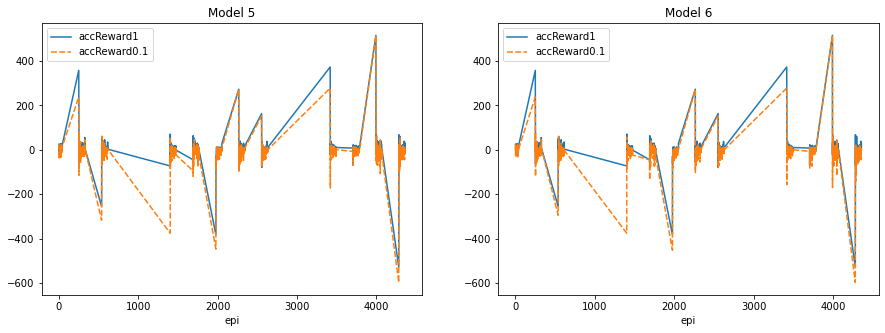

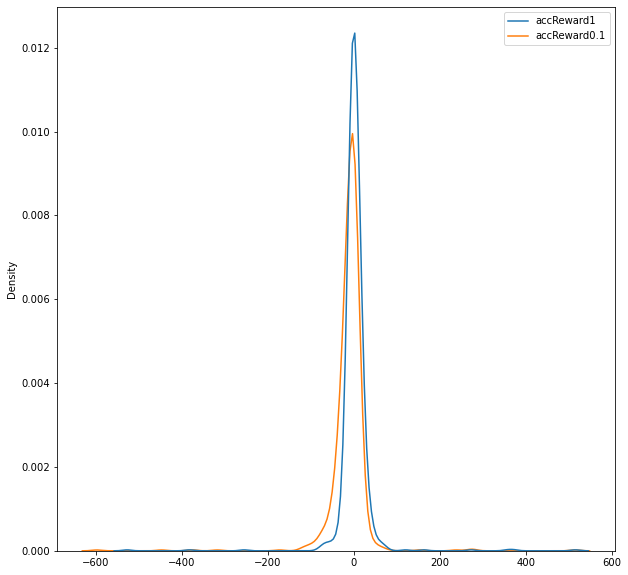

In [8]:
df['epi'] = df['epi'] - df['epi'].iloc[0] + 1
df2['epi'] = df2['epi'] - df2['epi'].iloc[0] + 1
# for original data
meanR1 = df['accReward1'].mean()
meanR01 = df['accReward0.1'].mean()
meanR02 = df2['accReward0.1'].mean()
# meanRSL = df['rewardSL'].mean()
# meanRTWAP = df['rewardTAWP'].mean()
print("mean: ", meanR1, meanR01, meanR02)

varR01 = (df['accReward0.1'] - df['accReward1']).var()
varR02 = (df2['accReward0.1'] - df2['accReward1']).var()
# varRSL = (df['rewardSL'] - df['accReward1']).var()
# varRTWAP = (df['rewardTAWP'] - df['accReward1']).var()
print("var: ", varR01, varR02)


# sharpe ratio
R01 = (15 + meanR01)/np.sqrt(varR01)
R02 = (15 + meanR02)/np.sqrt(varR02)
print("sharpe ratio: ", R01, R02)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=df[['epi', 'accReward1', 'accReward0.1']].groupby(['epi']).mean(), ax=axes[0]).set_title("Model 5")
sns.lineplot(data=df2[['epi', 'accReward1', 'accReward0.1']].groupby(['epi']).mean(), ax=axes[1]).set_title("Model 6")
plt.savefig(sInputFolder + '\\PerformanceReplay.png')

fig, axes = plt.subplots(1, figsize=(10, 10))
sns.kdeplot(data=df[['epi', 'accReward1', 'accReward0.1']].groupby(['epi']).mean(), ax=axes)

In [9]:
# sns.lineplot(data=df.loc[df['state']=='00021', 'optimalQ0.1'])
df01 = h5f[s][:]
df01.shape

(3, 3, 3, 3, 3, 10, 11, 2, 11, 897)

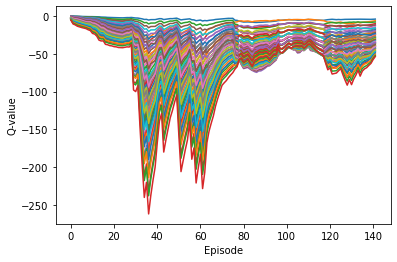

In [14]:
# convergence plot for simulated data of 2 weeks
actionSpace = np.arange(0, V + lot, lot)

# 'tradingVolBin', 'tradingImbBin', 'movingDiffBin', 'spreadBin', 'orderImbBin', time step, remaining shares, type of order, amount of order 
for i in [2]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df01[(0,0,0,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
plt.savefig(sInputFolder + '\\ConvergeReplayUni.png')

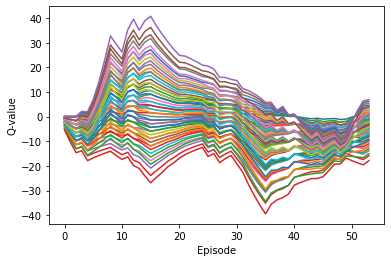

In [11]:
for i in [4]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df01[(0,0,1,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")

In [15]:
df02 = h5f2[s][:]

(3, 3, 3, 3, 3, 10, 11, 2, 11, 897)

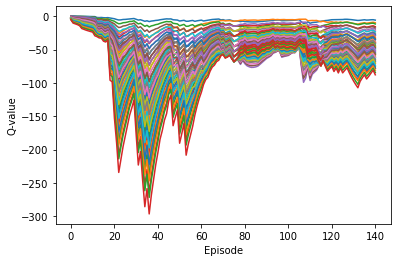

In [16]:
# 'tradingVolBin', 'tradingImbBin', 'movingDiffBin', 'spreadBin', 'orderImbBin', time step, remaining shares, type of order, amount of order 
for i in [2]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df02[(0,0,0,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")
plt.savefig(sInputFolder + '\\ConvergeReplayPrio.png')

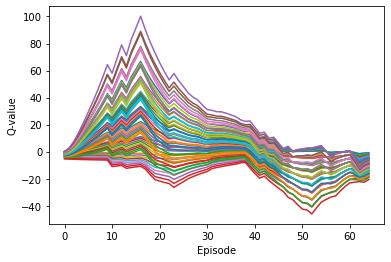

In [17]:
for i in [4]:
    for j in range(10):
        for k in [0]:
            for h in range(10):
                a = df02[(0,0,1,2,1,i,j,k,h)]
                a = a[~np.isnan(a)]
                ax = sns.lineplot(data=a)
                ax.set(xlabel="Episode", ylabel="Q-value")

In [13]:
df2.iloc[770:781]

,timeStamp,second,bestBidPrice,bestAskPrice,best2BidPrice,best2AskPrice,OFI,bidTradeSize,askTradeSize,marDep,...,aveMDBin,optimalQ0.1,optimalAType0.1,optimalA0.1,accReward0.1,optimalQ0.5,optimalAType0.5,optimalA0.5,accReward0.5,state
770,2019-10-01 15:55:00.018,23100.018,34.11,34.12,34.10,34.13,415,511,263,56243,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222020
771,2019-10-01 15:55:30.079,23130.079,34.15,34.16,34.14,34.17,3330,1395,530,143239,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222021
772,2019-10-01 15:56:00.995,23160.995,34.12,34.14,34.11,34.15,-1450,0,1643,59579,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202002
773,2019-10-01 15:56:30.308,23190.308,34.12,34.14,34.11,34.15,-700,14,0,42971,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122003
774,2019-10-01 15:57:00.400,23220.400,34.13,34.14,34.12,34.15,183,0,0,45868,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,002024
775,2019-10-01 15:57:31.673,23251.673,34.12,34.13,34.11,34.14,-1751,0,753,84960,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201005
776,2019-10-01 15:58:00.027,23280.027,34.12,34.13,34.11,34.14,-265,0,100,7321,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101006
777,2019-10-01 15:58:31.081,23311.081,34.13,34.14,34.12,34.15,1433,840,500,122316,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222027
778,2019-10-01 15:59:00.007,23340.007,34.14,34.16,34.13,34.17,3163,1967,1100,213534,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222028
779,2019-10-01 15:59:30.005,23370.005,34.13,34.14,34.12,34.15,-2038,500,1266,100852,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201009
